In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from random import shuffle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
df = pd.read_csv("./clean_data/fully_merged_data.csv")
df.shape

(68078, 9)

In [4]:
# delete empty values
df = df.dropna()
df.shape

(67927, 9)

In [5]:
# remove null values
arr = df.index[df["fel_misd"] == ' ']
df = df.drop(arr, axis=0)
arr = df.index[df["fel_misd"] == '\xa0']
df = df.drop(arr, axis=0)
df.shape

(65694, 9)

In [6]:
# z-score normalize desired columns
from scipy.stats import zscore

need_norm = ["age","MEDHINC_CY", "WLTHINDXCY", "TOTHH_CY"]
norm = df[need_norm].apply(zscore)
norm.head()

,age,MEDHINC_CY,WLTHINDXCY,TOTHH_CY
0,-1.007650,-0.795643,-0.502892,-0.442905
1,-1.007650,-0.795643,-0.502892,-0.442905
2,-0.759528,-0.788811,-0.373469,-0.405740
3,-0.759528,-0.788811,-0.373469,-0.405740
4,-1.007650,-0.795643,-0.502892,-0.442905


In [7]:
df[need_norm] = norm
df.head()

,sex,age,day,month,MEDHINC_CY,WLTHINDXCY,time_arr,TOTHH_CY,fel_misd
0,M,-1.007650,4,0,-0.795643,-0.502892,2310,-0.442905,M
1,M,-1.007650,4,0,-0.795643,-0.502892,2310,-0.442905,M
2,M,-0.759528,5,0,-0.788811,-0.373469,16,-0.405740,M
3,M,-0.759528,5,0,-0.788811,-0.373469,16,-0.405740,M
4,M,-1.007650,4,0,-0.795643,-0.502892,2310,-0.442905,M


In [8]:
df["fel_misd"].value_counts()

M    46803
F    16407
C     2194
S      240
P       50
Name: fel_misd, dtype: int64

In [9]:
m_arr = df.index[df["fel_misd"] == 'M'].tolist()
shuffle(m_arr)


df = df.drop(m_arr[0:len(m_arr)-2194], axis = 0)


s_arr = df.index[df["fel_misd"] == 'S'].tolist()
p_arr = df.index[df["fel_misd"] == 'P'].tolist()

f_arr = df.index[df["fel_misd"] == 'F'].tolist()
shuffle(f_arr)
df = df.drop(f_arr[0:len(f_arr)-2194], axis = 0)

df['fel_misd'].value_counts()

C    2194
F    2194
M    2194
S     240
P      50
Name: fel_misd, dtype: int64

In [10]:
def gen_rand_df(temp_df,samples=1):
    # Assume that temp_df is only populated with same fel_misd class and no one-hot 
    #     encoding
    # Age, MEDHINC_CY, WLTHINDXCY, time_arr, TOTHH_CY should be normalized prior
    #     to calling this function

    
    d = {}
    
    choices = temp_df['sex'].value_counts().index.to_list()
    v_c = temp_df['sex'].value_counts()
    probs = v_c/sum(v_c)
    d['sex'] = np.random.choice(choices, p=probs, size=samples)
    
    choices = temp_df['day'].value_counts().index.to_list()
    v_c = temp_df['day'].value_counts()
    probs = v_c/sum(v_c)    
    d['day'] = np.random.choice(choices, p=probs,size=samples)
    
    choices = temp_df['month'].value_counts().index.to_list()
    v_c = temp_df['month'].value_counts()
    probs = v_c/sum(v_c)    
    d['month'] = np.random.choice(choices, p=probs, size=samples)
    
    x = np.random.normal(0,1,size=(5,samples))
    d['age'] = x[0]
    d['MEDHINC_CY'] = x[1]
    d['WLTHINDXCY'] = x[2]
    d['time_arr'] = x[3]
    d['TOTHH_CY'] = x[4]
    d['fel_misd'] = [temp_df['fel_misd'].to_list()[0] for i in range(samples)]
    
    df_return = pd.DataFrame.from_dict(d)

    
    return df_return

s_amt = (int) (0.5*240)  
p_amt = (int) (0.5*50)    
inp = df[df['fel_misd'] == 'S']
s_temp = gen_rand_df(inp,s_amt)

inp = df[df['fel_misd'] == 'P']
p_temp = gen_rand_df(inp,p_amt)

df = pd.concat([df,s_temp,p_temp])
df.shape, df['fel_misd'].value_counts()

((7017, 9),
 C    2194
 F    2194
 M    2194
 S     360
 P      75
 Name: fel_misd, dtype: int64)

In [11]:
df_pandas_encoded = pd.get_dummies(df, columns=['sex', 'day', 'month'], drop_first=True)
df_pandas_encoded = df_pandas_encoded.drop("WLTHINDXCY", axis=1)
df_pandas_encoded.head()

,age,MEDHINC_CY,time_arr,TOTHH_CY,fel_misd,sex_M,sex_U,day_1,day_2,day_3,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
7,-0.759528,-0.788811,16.0,-0.405740,C,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,-1.173064,-0.174385,2317.0,0.805843,F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,-0.180577,0.016459,419.0,0.379188,F,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,-1.007650,-0.174385,155.0,0.805843,F,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,-0.511406,-0.009893,249.0,-1.133433,F,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
inp = list(df_pandas_encoded.columns)
# oup = ['fel_misd_0.0',
#      'fel_misd_1.0',
#      'fel_misd_2.0',
#      'fel_misd_3.0',
#      'fel_misd_4.0',
#      'fel_misd_5.0']
oup = ["fel_misd"]
for x in oup:
    inp.remove(x)
inp, oup

(['age',
  'MEDHINC_CY',
  'time_arr',
  'TOTHH_CY',
  'sex_M',
  'sex_U',
  'day_1',
  'day_2',
  'day_3',
  'day_4',
  'day_5',
  'day_6',
  'month_1',
  'month_2',
  'month_3',
  'month_4',
  'month_5',
  'month_6',
  'month_7',
  'month_8',
  'month_9',
  'month_10',
  'month_11'],
 ['fel_misd'])

In [13]:
x,y = df_pandas_encoded[inp], df_pandas_encoded[oup]
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8, test_size=0.2)

In [14]:
import itertools
items = ['MEDHINC_CY','age','sex_M', 'day', 'month']
combs = []
for i in range(1, len(items)):
    combs.append(list(set(itertools.combinations(items, i))))

In [15]:
day_vals = ['day_1',
          'day_2',
          'day_3',
          'day_4',
          'day_5',
          'day_6']

month_vals = ['month_1',
              'month_2',
              'month_3',
              'month_4',
              'month_5',
              'month_6',
              'month_7',
              'month_8',
              'month_9',
              'month_10',
              'month_11']

best_dict = {"features": [], "score": -2**31}
for k_amt in combs:
    for ind_comb in k_amt:
        comb = list(ind_comb)
        if 'day' in comb:
            comb.remove('day')
            comb += day_vals
        if 'month' in comb:
            comb.remove('month')
            comb += month_vals

        
        x_subset = x_train[comb].values
        cvs = cross_val_score(linear_model.LogisticRegression(multi_class='ovr'), x_subset, y_train)
        
        if cvs.mean() > best_dict["score"]:
            best_dict["features"] = comb
            best_dict["score"] = cvs.mean()
best_dict

{'features': ['age',
  'sex_M',
  'day_1',
  'day_2',
  'day_3',
  'day_4',
  'day_5',
  'day_6',
  'month_1',
  'month_2',
  'month_3',
  'month_4',
  'month_5',
  'month_6',
  'month_7',
  'month_8',
  'month_9',
  'month_10',
  'month_11'],
 'score': 0.3898116358176072}

In [16]:
log_r = linear_model.LogisticRegression(penalty='l2', multi_class="ovr")

In [17]:
best_dict["features"]

['age',
 'sex_M',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11']

In [18]:
x_train = x_train[best_dict["features"]]
x_test = x_test[best_dict["features"]]

log_r.fit(x_train, y_train)

LogisticRegression(multi_class='ovr')

In [19]:
y_pred = log_r.predict(x_test)
print(f"Accuracy train: {log_r.score(x_train,y_train)}")
print(f"Accuracy Test: {log_r.score(x_test,y_test)}")

Accuracy train: 0.3953322643862462
Accuracy Test: 0.37962962962962965


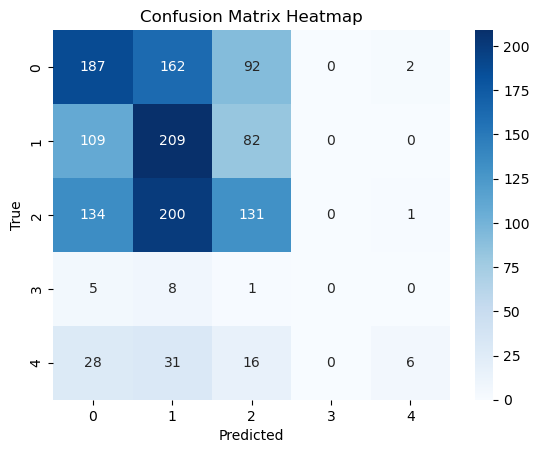

In [20]:
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix Heatmap")
plt.show()

In [21]:
cm

array([[187, 162,  92,   0,   2],
       [109, 209,  82,   0,   0],
       [134, 200, 131,   0,   1],
       [  5,   8,   1,   0,   0],
       [ 28,  31,  16,   0,   6]])

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.40      0.42      0.41       443
           F       0.34      0.52      0.41       400
           M       0.41      0.28      0.33       466
           P       0.00      0.00      0.00        14
           S       0.67      0.07      0.13        81

    accuracy                           0.38      1404
   macro avg       0.36      0.26      0.26      1404
weighted avg       0.40      0.38      0.37      1404



In [23]:
inp = list(df_pandas_encoded.columns)
oup = ["MEDHINC_CY"]
for x in oup:
    inp.remove(x)
inp.remove('fel_misd')
inp, oup

(['age',
  'time_arr',
  'TOTHH_CY',
  'sex_M',
  'sex_U',
  'day_1',
  'day_2',
  'day_3',
  'day_4',
  'day_5',
  'day_6',
  'month_1',
  'month_2',
  'month_3',
  'month_4',
  'month_5',
  'month_6',
  'month_7',
  'month_8',
  'month_9',
  'month_10',
  'month_11'],
 ['MEDHINC_CY'])

In [24]:
x,y = df_pandas_encoded[inp], df_pandas_encoded[oup]
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8, test_size=0.2)

In [25]:
items = ['age','sex_M', 'day', 'month']
combs = []
for i in range(1, len(items)):
    combs.append(list(set(itertools.combinations(items, i))))

In [26]:
day_vals = ['day_1',
          'day_2',
          'day_3',
          'day_4',
          'day_5',
          'day_6']

month_vals = ['month_1',
              'month_2',
              'month_3',
              'month_4',
              'month_5',
              'month_6',
              'month_7',
              'month_8',
              'month_9',
              'month_10',
              'month_11']

best_dict = {"features": [], "score": -2**31, "alpha": 0}
alpha_vals = np.logspace(-1,3,50)
for k_amt in combs:
    for ind_comb in k_amt:
        comb = list(ind_comb)
        if 'day' in comb:
            comb.remove('day')
            comb += day_vals
        if 'month' in comb:
            comb.remove('month')
            comb += month_vals

        
        x_subset = x_train[comb].values
        
        for alpha in alpha_vals:
            cvs = cross_val_score(linear_model.Ridge(alpha=alpha), x_subset, y_train)
        
        if cvs.mean() > best_dict["score"]:
            best_dict["features"] = comb
            best_dict["score"] = cvs.mean()
best_dict

{'features': ['sex_M',
  'day_1',
  'day_2',
  'day_3',
  'day_4',
  'day_5',
  'day_6',
  'month_1',
  'month_2',
  'month_3',
  'month_4',
  'month_5',
  'month_6',
  'month_7',
  'month_8',
  'month_9',
  'month_10',
  'month_11'],
 'score': 0.001717309571755221,
 'alpha': 0}

In [27]:
lasso = linear_model.LassoLarsCV(cv=20)
lasso.fit(x_train, y_train)
lasso_mse=lasso.mse_path_
lasso_alphas = lasso.cv_alphas_
mse_mean = []
mse_std = []
for i in range(len(lasso_mse)):
    mse_mean.append(lasso_mse[i].mean())
    mse_std.append(lasso_mse[i].std())
    
min_alpha = lasso_alphas[np.argmin(mse_mean)]
print(f"Best Average MSE: {min(mse_mean)} with {min_alpha=}")

Best Average MSE: 1.0605850204534664 with min_alpha=0.002263664035584396


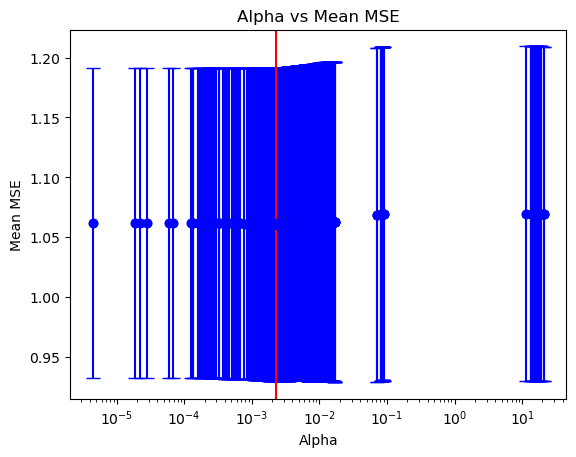

In [28]:
plt.errorbar(lasso_alphas,mse_mean, yerr=mse_std,fmt="o", capsize=5, color="blue")
plt.scatter(lasso_alphas, mse_mean, color='blue')
plt.xscale('log')

plt.axvline(x=min_alpha, color='red')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('Alpha vs Mean MSE');

In [29]:
# Ridge alpha is 0, use linear regression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Ridge.html
# Lasso alpha is 0.0067 try lasso
lr = linear_model.LinearRegression()

x_train = x_train[best_dict["features"]]
x_test = x_test[best_dict["features"]]

lr.fit(x_train, y_train)

LinearRegression()

In [30]:
y_pred = lr.predict(x_test)
print(f"R2 train: {lr.score(x_train,y_train)}")
print(f"R2 Test: {lr.score(x_test,y_test)}")

R2 train: 0.007732878207017402
R2 Test: -0.006348696956281152


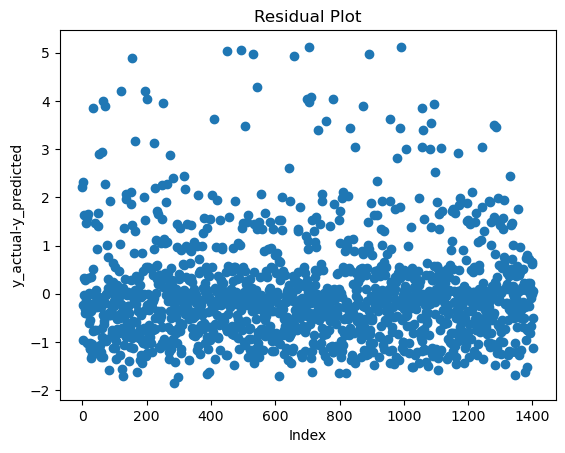

In [31]:
plt.scatter([i for i in range(len(y_test))],y_test-y_pred);
plt.xlabel("Index")
plt.ylabel("y_actual-y_predicted")
plt.title("Residual Plot");

In [32]:
lr_lasso = linear_model.Lasso(alpha=min_alpha)
lr_lasso.fit(x_train, y_train)

Lasso(alpha=0.002263664035584396)

In [33]:
y_lasso_pred = lr_lasso.predict(x_test)
print(f"R2 train: {lr_lasso.score(x_train,y_train)}")
print(f"R2 Test: {lr_lasso.score(x_test,y_test)}")

R2 train: 0.0067741238640351975
R2 Test: -0.0029514786721556163


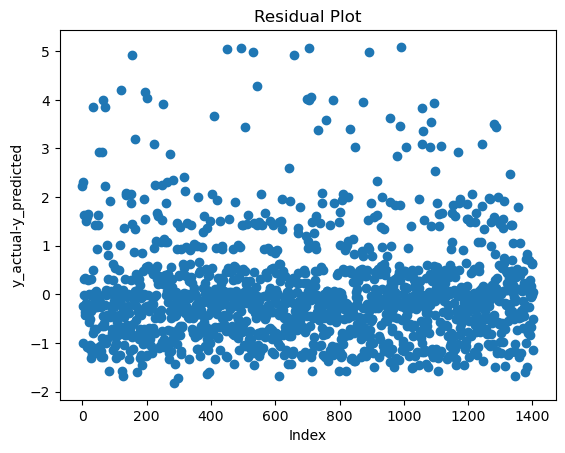

In [34]:
plt.scatter([i for i in range(len(y_test))],y_test.values.reshape(-1)-y_lasso_pred);
plt.xlabel("Index")
plt.ylabel("y_actual-y_predicted")
plt.title("Residual Plot");

In [35]:
# Insert code here
df1 = pd.DataFrame(lr.coef_, columns=lr.feature_names_in_)
df2 = pd.DataFrame(lr_lasso.coef_.reshape(1,-1), columns=lr_lasso.feature_names_in_)
df = pd.concat([df1,df2])
df["Name"] = ["Linear Regression", "Lasso"]
df = df.set_index(df["Name"])
df = df.drop("Name", axis=1)
df

,sex_M,day_1,day_2,day_3,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
Name,,,,,,,,,,,,,,,,,,
Linear Regression,-0.085311,-0.143653,-0.138616,-0.120045,-0.105102,0.037865,-0.045839,0.039248,0.038710,-0.00679,-0.044321,0.077754,-0.134486,-0.033714,-0.064266,0.001141,-0.040008,-0.005866
Lasso,-0.073374,-0.077361,-0.070978,-0.054890,-0.041404,0.070885,0.000000,0.031765,0.023798,0.00000,-0.005044,0.056212,-0.094996,-0.000000,-0.024385,0.000000,-0.000000,0.000000


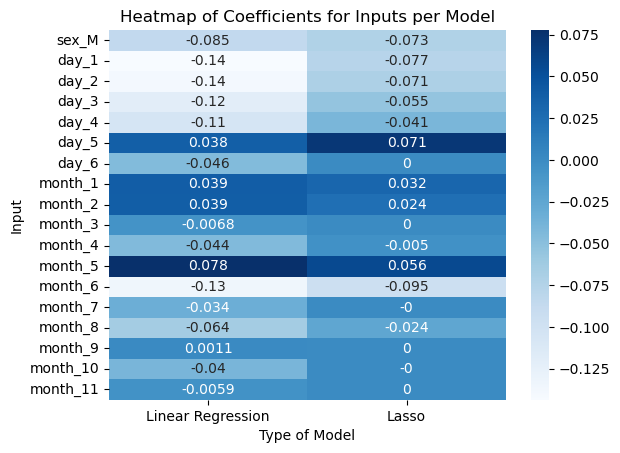

In [36]:
sb.heatmap(df.T, annot=True, cmap='Blues')
plt.xlabel('Type of Model')
plt.ylabel('Input')
plt.title("Heatmap of Coefficients for Inputs per Model")
plt.show()

In [37]:
df = pd.DataFrame(log_r.coef_, columns=log_r.feature_names_in_)
df = df.set_index(log_r.classes_)
df

,age,sex_M,day_1,day_2,day_3,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
C,-0.009596,-0.083497,-0.266804,-0.311749,-0.440378,-0.372277,-0.181663,0.202032,0.079770,-0.083017,-0.575952,-0.302922,-0.404571,-0.541853,-0.242202,0.154476,-0.016851,0.200020,0.166649
F,0.030997,0.573335,0.258559,0.446821,0.634505,0.553481,0.347846,-0.076487,-0.154931,-0.031952,-0.052786,-0.062608,-0.170571,0.177756,0.136333,0.159992,0.011649,-0.270993,-0.024495
M,0.132008,-0.231506,-0.038701,-0.321148,-0.270876,-0.122991,-0.143900,-0.209236,-0.064668,0.002464,0.228860,0.150378,0.412698,0.064237,0.101392,-0.349431,0.005243,0.001206,-0.134353
P,-0.190370,-0.081304,-0.299312,-0.272421,0.055796,0.163838,-0.165017,-0.001258,0.541934,0.234130,-1.247884,-0.692202,0.193684,0.136302,-1.334794,-0.711909,-0.042350,-0.377411,0.348709
S,-0.921119,-0.840697,0.348098,0.806603,0.268774,-0.429575,0.007588,0.275362,0.470978,0.525339,1.349862,1.018563,0.566301,1.036418,0.264292,0.170568,-0.085619,0.297631,-0.395498


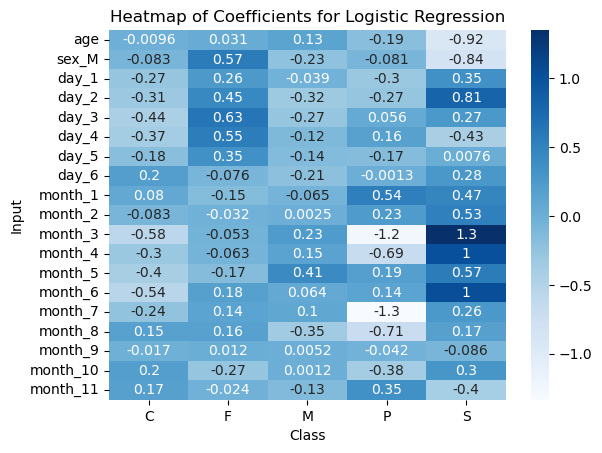

In [38]:
sb.heatmap(df.T, annot=True, cmap='Blues')
plt.xlabel('Class')
plt.ylabel('Input')
plt.title("Heatmap of Coefficients for Logistic Regression")
plt.show()